<a href="https://colab.research.google.com/github/srodney/diffimageml/blob/main/diffimageml/examples/vgg16_keras_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Demo of the keras vgg16 implementation

ML warmup: shows a demo classification of cats and dogs images from imagenet db.  See, for example: 

https://www.kaggle.com/shaochuanwang/keras-warm-up-cats-vs-dogs-cnn-with-vgg16

https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/


In [12]:
import os
import shutil
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import zipfile

import tensorflow as tf
from tensorflow import keras

In [13]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [14]:
%matplotlib inline

# Get the example image data

## Option 1: from Google Drive (default)

Grab the pre-fetched Kaggle zip file from a public Google Drive link.

See the "Fetch and set up the Data" section below


## Option 2: Get the data directly from Kaggle to Colab

To get the training data directly from Kaggle to Google Colab, do the following:
1. log in to Kaggle (register for an account if needed)
2. Visit the Dogs vs Cats competition: https://www.kaggle.com/c/dogs-vs-cats/data
3. accept the competition rules (you must do this before you can download the data using the API)
4. Follow the steps described here: https://www.kaggle.com/general/74235

## Fetch and set up the data

Here we download a zip file with the example training/validation and test data from Google Drive, unpack it, sort the data into subdirs by class, and load it into keras data generator objects.

In [15]:
# Grab the pre-fetched data from Google Drive
# Gets placed into /content/dogs-vs-cats.zip
zipfilename = "/content/dogs-vs-cats.zip"
if os.path.isfile(zipfilename):
  os.remove(zipfilename)
!gdown --id 1xXZYJZkOzajQpHLPUvw9LzUq-zYIqbKa

print(f"Got zip file? {os.path.exists(zipfilename)}")
print(f"File size = {os.stat(zipfilename).st_size} bytes")

Downloading...
From: https://drive.google.com/uc?id=1xXZYJZkOzajQpHLPUvw9LzUq-zYIqbKa
To: /content/dogs-vs-cats.zip
852MB [00:08, 95.8MB/s]
Got zip file? True
File size = 851576689 bytes


In [16]:
# unzip the top-level zip file into a local Colab data directory
datadir = "dogs_vs_cats_data"

with zipfile.ZipFile(zipfilename, 'r') as zip_ref:
    zip_ref.extractall(datadir)

# unzip the training/validation data : unpacks into a directory labeled 'train'
trainzipfilepath = os.path.join(datadir, "train.zip")
with zipfile.ZipFile(trainzipfilepath, 'r') as zip_ref:
    zip_ref.extractall(datadir)
 
traindatadir = os.path.join(datadir, "train")

assert(os.path.exists(traindatadir))
print(f"Unpacked training data into {os.path.abspath(traindatadir)}")

Unpacked training data into /content/dogs_vs_cats_data/train


In [17]:
imagelist = glob.glob(traindatadir + '/*jpg')
print(f"Total Number of images = {len(imagelist)}")

# Sort the data into two sub-directories based on class
classnames = ["cat", "dog"]
for classname in classnames:
  classdir = os.path.join(traindatadir, classname)
  if not os.path.isdir(classdir):
    os.mkdir(classdir)
  classfilelist = glob.glob(traindatadir + f'/{classname}*jpg')
  print(f"Number of {classname} images = {len(classfilelist)}")
  for filename in classfilelist:
    shutil.move(filename, classdir)



Total Number of images = 25000
Number of cat images = 12500


Error: ignored

# Set up the Data Generators

Construct a data generator for training and validation, with an 80/20 split.

Options below to adjust the image target image size, and to use image augmentation. 

In [ ]:
imagesize = 200 # pixels - fixing to square image arrays
use_augmentation = False # set to true to include shifts and flip
valsplit = 0.2  # fraction of available training data to use for validation

# Create the data generator, with or without augmentation
if use_augmentation:
  datagen = ImageDataGenerator(rescale=1.0/255.0, width_shift_range=0.1, 
                               height_shift_range=0.1, horizontal_flip=True, 
                               validation_split=valsplit)
else:    
  datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=valsplit)


print('Training data set (80%):')
train_it = datagen.flow_from_directory(
    directory=traindatadir, class_mode='binary', batch_size=64, 
    target_size=(imagesize, imagesize), subset='training')    

print('\n Validation data set (20%):')   
test_it = datagen.flow_from_directory(
    directory=traindatadir, class_mode='binary', batch_size=64, 
    target_size=(imagesize, imagesize), subset='validation')


# Define Models

These functions define three different CNNs:  a one-block, a two-block, and the VGG16 model.

In [ ]:
# define cnn model
def define_model_1():
    ##One Block CNN
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(imagesize, imagesize, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model
 
def define_model_1_dropout():
    model = Sequential()
    model.add(Dropout(0.2))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(imagesize, imagesize, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model
    
def define_model_2():
    
    #Two Block CNN
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(imagesize, imagesize, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    return model
    
def VGG16():
    model = Sequential()
    model.add(Conv2D(input_shape=(imagesize,imagesize,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),name='vgg16'))
    model.add(Flatten(name='flatten'))
    model.add(Dense(256, activation='relu', name='fc1'))
    model.add(Dense(128, activation='relu', name='fc2'))
    model.add(Dense(1, activation='sigmoid', name='output'))
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.legend()
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    plt.savefig(filename + '_plot.png')
    plt.close()


# run the test harness for evaluating a model
def run_test_harness():
    # define model
    model = define_model_2()

    # fit model
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
        validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=1)
    # evaluate model
    _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    print('> %.3f' % (acc * 100.0))
    # learning curves
    summarize_diagnostics(history)
    
    model.save('final_model.h5')

# Run the model training

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
313/313 [==============================] - 73s 230ms/step - loss: 0.7315 - accuracy: 0.5138 - val_loss: 0.6864 - val_accuracy: 0.5776
Epoch 2/50
313/313 [==============================] - 72s 231ms/step - loss: 0.6868 - accuracy: 0.5384 - val_loss: 0.6850 - val_accuracy: 0.5798
Epoch 3/50
313/313 [==============================] - 72s 230ms/step - loss: 0.6871 - accuracy: 0.5380 - val_loss: 0.6818 - val_accuracy: 0.5758
Epoch 4/50
313/313 [==============================] - 72s 231ms/step - loss: 0.6816 - accuracy: 0.5643 - val_loss: 0.6798 - val_accuracy: 0.5832
Epoch 5/50
313/313 [==============================] - 72s 230ms/step - loss: 0.6801 - accuracy: 0.5638 - val_loss: 0.6825 - val_accuracy: 0.5848
Epoch 6/50
313/313 [==============================] - 72s 231ms/step - loss: 0.6779 - accuracy: 0.5716 - val_loss: 0.6778 - val_accuracy: 0.5940
Epoch 7/50
313/313 [==============================] - 72s 231ms/step - loss: 0.6731 - accuracy: 0.5857 - val_loss: 0.6711 - val_ac

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


> 75.380


NameError: ignored

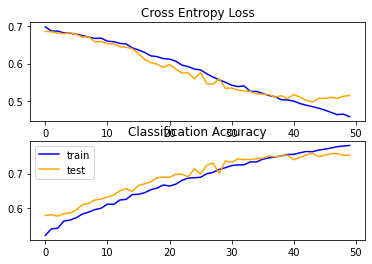

In [11]:
run_test_harness()